In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# df: dataframe of any certain factor
# _d: daily data; _m: monthly data; _div: dividend
# _c: stock_close_price   row:date; column:stock_code   
# _v: stock_volume   成交量
# _tr: stock_turnover_rate
# _sn: share number 流通股本

# 对每月月底的数据进行操作
# backsee 回溯的天数（数据量）
# df_cmv： circulation_market_value

In [3]:
import scipy.io as scio

def read_mat(path,start,end):
    """
    读取mat文件
    """
    col=list(scio.loadmat('./Data/AllStockCode.mat').values())[3]
    index=list(scio.loadmat('./Data/TradingDate_Daily.mat').values())[3]
    col=[i[0] for i in col[0]]
    index=[i for i in index]
    data=list(scio.loadmat(path).values())[3]
    data=pd.DataFrame(data,index=index,columns=col)
    data=data.reset_index()
    data['level_0']=data['level_0'].astype('str')# reset之后原index保留为 level0
    data['level_0']=pd.to_datetime(data['level_0'],format='%Y%m%d')
    data=data.rename(columns={'level_0':'Date'})
    data=data.replace(0,np.nan) # Now the DataFrame will have NaN instead of 0 values
    data=data[(data['Date']>=start)&(data['Date']<=end)]
    data=data.set_index('Date',drop='True')
    return data


## Load the data

In [4]:
start='2014-01-01'
end='2023-7-31'
# daily price data
df_c_d = read_mat('./Data/AllStock_DailyClose.mat', start, end)
df_o_d = read_mat('./Data/AllStock_DailyOpen.mat', start, end)
df_h_d = read_mat('./Data/AllStock_DailyHigh.mat', start, end)
df_l_d = read_mat('./Data/AllStock_DailyLow.mat', start, end)

# daily dividend price data
df_c_div_d = read_mat('./Data/AllStock_DailyClose_dividend.mat', start, end)
df_o_div_d = read_mat('./Data/AllStock_DailyOpen_dividend.mat', start, end)
df_h_div_d = read_mat('./Data/AllStock_DailyHigh_dividend.mat', start, end)
df_l_div_d = read_mat('./Data/AllStock_DailyLow_dividend.mat', start, end)

# daily trading data
df_sn_d = read_mat('./Data/AllStock_DailyAShareNum.mat', start, end)
df_ld_d = read_mat('./Data/AllStock_DailyListedDate.mat',start, end)
df_st_d = read_mat('./Data/AllStock_DailyST.mat',start, end)
df_sta_d = read_mat('./Data/AllStock_DailyStatus.mat',start, end)
df_v_d = read_mat('./Data/AllStock_DailyVolume.mat',start, end)
df_tr_d = read_mat('./Data/AllStock_DailyTR.mat',start, end)

#all close data(for the check of sub_new stock)
df_c_all = read_mat('./Data/AllStock_DailyClose.mat', '2004-01-02', end)

In [5]:
def MACD(df_c,lag_short, lag_long, lag_dea):
    """
    短期指数移动平均线和长期指数移动平均线的聚合、分离情况
    """
    short_ema = df_c.ewm(span = lag_short).mean()
    long_ema = df_c.ewm(span = lag_long).mean()#计算移动加权平均线
    diff = short_ema - long_ema
    dea = diff.ewm(span = lag_dea).mean()
    macd = 2 *(diff - dea)
    return macd

def AMA(df_c, lag_short, lag_long):
    short_ema = df_c.ewm(span = lag_short).mean()
    long_ema = df_c.ewm(span = lag_long).mean()
    return (short_ema/long_ema).ewm(span = lag_short).mean()


def VHF(df_c, lag):
    high = df_c.rolling(window = lag, min_periods = 1).max()
    low = df_c.rolling(window = lag, min_periods = 1).min()
    diff_price = df_c.diff(periods = 1)
    total_asb_change = diff_price.abs().rolling(window = lag, min_periods = 1).sum()
    return (high - low)/total_asb_change


def ForceIndex(df_c, df_t, lag):
    ret = df_c/df_c.shift(1) - 1
    forceindex = (ret * df_t).rolling(window = lag, min_periods = 1).mean()
    return forceindex
    
def VR(df_c, df_v, lag):
    ret = df_c/df_c.shift(1) - 1
    volume_up = df_v.copy()
    volume_down = df_v.copy()
    volume_up[ret < 0] = 0
    volume_down[ret > 0] = 0
    vr = volume_up.rolling(window = lag, min_periods = 1).mean()/volume_down.rolling(window = lag, min_periods = 1).mean()
    return vr

    
def OBV(df_c, df_v, lag):
    d = (df_c > df_c.shift(1)).astype(int)
    d[d==0] = -1
    obv = (d * df_v).rolling(window = lag, min_periods = 1).mean()
    return obv
    
    
def TRIX(df_c, lag_short, lag_long):
    short = df_c.rolling(window = lag_short, min_periods = 1).mean()
    long = df_c.rolling(window = lag_long, min_periods = 1).mean()
    trix = short/long - 1
    return trix

In [6]:
#Oscillation
def RVI(df_c, df_o,df_h, df_l, lag):
    """
    Relative Vigor Index:High RVI values are interpreted as overbought conditions in the market, 
    indicating that the market may be overheating.
    Undividended data.
    """
    MovAverage = (df_c - df_o).rolling(window = lag, min_periods = 1).mean()
    RangeAverage = (df_h - df_l).rolling(window = lag, min_periods = 1).mean()
    rvi = MovAverage/RangeAverage
    return rvi

def BIAS(df_c, lag):
    MA = df_c.rolling(window = lag, min_periods = 1).mean()
    bias = df_c/MA - 1
    return bias

def KDJ(df_l, df_h, df_c, lag):
    low = df_l.rolling(window = lag, min_periods = 1).min()
    high = df_h.rolling(window = lag, min_periods = 1).max()
    rsv = (df_c - low) / (high - low) * 100
    KDJ_K = rsv.ewm(adjust = False, alpha = 1/3).mean()
    KDJ_D = KDJ_K. ewm(adjust = False, alpha = 1/3).mean()
    KDJ_J = 3*KDJ_K - 2*KDJ_D
    return KDJ_J

def RSI(df_c, lag):
    P_delta = df_c - df_c.shift(1)
    P_delta_pos = P_delta.copy()
    P_delta_pos[P_delta<=0] = 0
    P_delta_neg = P_delta.copy()
    P_delta_neg [P_delta>=0] = 0
    P_delta_up = P_delta_pos.rolling(window = lag, min_periods = 1).mean()
    P_delta_down = P_delta_neg.rolling(window = lag, min_periods = 1).mean()
    RS = P_delta_up/P_delta_down
    rsi = 100 - 100/ (1 + RS.abs())
    return rsi

def CMO(df_c, lag):
    P_delta = df_c - df_c.shift(1)
    P_delta_up = P_delta.copy()
    P_delta_down = P_delta.copy()
    P_delta_up[P_delta < 0] = 0
    P_delta_down[P_delta > 0] = 0
    P_delta_up_sum = P_delta_up.rolling(window = lag, min_periods = 1).sum ()
    P_delta_down_sum = P_delta_down.rolling(window = lag, min_periods = 1).sum ()
    cmo = (P_delta_up_sum + P_delta_down_sum)/(P_delta_up_sum - P_delta_down_sum)
    return cmo

## Factor construction

月频因子
日频因子值-->月频因子 （回看二十个交易日还是按照时间来定）
最后一个交易日的流通股本*复权收盘价

按照回看交易日



In [7]:
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression

def DaytoMon(df, window =20, threshold =10):
    
    #先将原始数据回看二十天取均值，在resample按月划分
    #resample会将index自动归位每月最后一天，不影响计算数据
    
    daily_mean = df.rolling(window = window, min_periods = threshold).mean() 
    monthly_factor_raw = daily_mean.resample('M').last()
    
    return monthly_factor_raw

# 自实现3倍中位数绝对偏差去极值

def MAD(factor):
    med = np.median(factor)
    mad = np.median(abs(factor - med))
    
    # 求出3倍中位数的上下限制
    up = med + (3*1.4826*mad)
    down = med - (3*1.4826*mad)
    
    # 利用3倍中位数的值去极值
    factor = np.where(factor>up,up,factor)
    factor = np.where(factor<down,down,factor)
    
    return factor


def Neutralization(df, df_cmv, window = 20, threshold = 10):
    '''
    Factor neutralization
    ''' 
    neutralized_factor = df.copy()
    for i in range(neutralized_factor.shape[0]):
        y = MAD(df.iloc[i, :].values)
        x = np.log(df_cmv.iloc[i, :].values)
        non_nan_indices = ~np.isnan(x) & ~np.isnan(y)
        slope, intercept,r_value, p_value, std_err= linregress(y[non_nan_indices], x[non_nan_indices])
        neutralized_factor.iloc[i, :] = y - (intercept + slope*x)
    return neutralized_factor

def CirculationMarketValue(df_sn, df_c_div):
    '''
    流通市值 = 交易日流通股本*交易日收盘价
    '''
    return df_sn * df_c_div

def FactorConstruction(df_d):
    df_m = DaytoMon(df_d)
    df_cmv_d = CirculationMarketValue(df_sn_d, df_c_div_d)
    df_cmv_m = df_cmv_d.resample('M').last()
    return Neutralization(df_m, df_cmv_m)

## Factor backtest
如何处理停牌、ST、涨跌停股?

In [8]:
#Factor preprocess and constraints preparation
#Factor = Factor * ST * Halt * Sub_new * Limit_up

#ST 
#monthly, nan for st and 1 for non-st, eliminate the stock when it is st last month
df_st_m = df_st_d.replace(np.nan, 0).resample('M').mean()
df_st_m = df_st_m.applymap(lambda x: np.nan if x > 0.5 else 1)

#Halt stock(status)
#monthly，nan for suspended stock and 1 for normal, eliminate the stock when it is suspended last month
df_sta_m = df_sta_d.replace(np.nan, 0).resample('M').mean()
df_sta_m = df_sta_m.applymap(lambda x: 1 if x > 0.5 else np.nan)

#Sub_new
#subnew 需要借助全部日期信息，最后取截断
df_subnew_d = df_c_all.where(df_c_all.isna(),1)
df_subnew_d = df_subnew_d.apply(lambda x:x.cumsum())
df_subnew_m = df_subnew_d.resample('M').last()
df_subnew_m = df_subnew_m.applymap(lambda x: 1 if x >= 60 else np.nan)

df_subnew_m = df_subnew_m[(df_subnew_m.index >= start) & (df_subnew_m.index <= end)]

#what about limit up and down
daily_return = (df_o_div_d / df_c_div_d) - 1 # there's nan values

#buy for limit up, nan: you can not purchase the stock, 1:you can purchase the stock
df_lu_m = daily_return.replace(np.nan,0).resample('M').last()
df_lu_m = df_lu_m.applymap(lambda x: np.nan if x > 0.1 else 1)



#sell for limit down, used in the backtest part not the preparation(by keeping the group)

df_ld_m = daily_return.replace(np.nan,0).resample('M').last()
df_ld_m = df_ld_m.applymap(lambda x: np.nan if x <-0.1 else 1)

In [9]:
# monthly close price, open price 
df_c_div_m = df_c_div_d.resample('M').last()
df_o_div_m = df_o_div_d.resample('M').first()
df_return_rate_m = df_c_div_m / df_o_div_m - 1

def Factor_backtest(df, hedge_method = '10-1'):
    '''
    df: factors by the end of month
    df_c_div: dividend close value by the end of month
    df_o_div: dividend open value by the start of month
    '''
    df = df * df_st_m * df_sta_m * df_subnew_m * df_lu_m
    df_c_div = df_c_div_m
    df_o_div = df_o_div_m
    
    #net / rate dataframe initialization
    columns = ['group1', 'group2', 'group3', 'group4','group5', 'group6','group7', 'group8','group9', 'group10','hedge']
    group_rate = pd.DataFrame(index = df.index, columns=columns)
    group_net = pd.DataFrame(index = df.index, columns=columns)
    group_rate.iloc[0, :] = 0
    
    #Initialize the group transfer indicator
    group_transfer = pd.Series(0, index = df.columns)
    
    for i in range(df.shape[0] - 1): 
        factor = df.iloc[i,:].to_frame()
        open_price = df_o_div.iloc[(i+1), :].to_frame()
        close_price = df_c_div.iloc[(i+1), :].to_frame()
        return_rate = df_return_rate_m.iloc[(i+1), :].to_frame()
        ld_indicator = np.isnan(df_ld_m.iloc[(i + 1), :].to_frame())
        df_temp = pd.concat([factor,open_price, close_price, return_rate, ld_indicator], axis=1)
        column_names = ['factor','open_price', 'close_price', 'return_rate', 'limit_down_indicator']
        df_temp.columns =  column_names
        
        # 排序，十分组
        df_temp_sorted = df_temp.sort_values(by = 'factor')
        df_temp_sorted = df_temp_sorted.dropna(axis = 0) # little bit weird,axis 表示按照轴的方向进行操作， axis = 0 按照行的方向
        df_temp_sorted.drop(df_temp_sorted[df_temp_sorted['return_rate'] > 20].index, inplace = True)# 剔除极端异常值（return rate = 900）
        df_temp_sorted['Group'] = pd.qcut(df_temp_sorted['factor'], q=10, labels=False) + 1#qcut 分位数划分，保证每个范围内的观测差不多，cut是按照factor 数值范围十等分
        
 
        for stock in df_temp_sorted.index:
            if (stock in group_transfer.index) and (group_transfer.loc[stock] != 0):
                df_temp_sorted.loc[stock, 'Group'] = group_transfer.loc[stock]
                
        group_mean = df_temp_sorted.groupby('Group')['return_rate'].mean().values
        
        group_transfer = df_temp_sorted['Group'] * df_temp_sorted['limit_down_indicator']
        
        
        '''
        Debug
        #print(i)
        #print(df_temp_sorted)
        #print(group_mean.shape)
        #print(group_rate.iloc[(i+1), :].shape)
        '''
        
        #gruop_rate 赋值
        #hedging (group10 - group1) or (group1 - group 10)
        group_rate.iloc[(i+1), : -1] = group_mean
        
        if hedge_method == '10-1':
            group_rate.iloc[(i+1), -1] = group_mean[-1] - group_mean[0]
        else:
            group_rate.iloc[(i+1), -1] = group_mean[0] - group_mean[-1]
                
    #group net construction
    for i in range(group_net.shape[0]):
        for j in range(group_net.shape[1]):
            group_net.iloc[i,j] = (group_rate.iloc[0 : i, j]+1).product()
        #backsee test
    
    fig, ax1 = plt.subplots(figsize= (15, 8))
    
    for column in columns[:-1]:
        ax1.plot(group_net.index, group_net[column], label = column)
    
    ax2 = ax1.twinx()
    if hedge_method == '10-1':
        ax2.plot(group_net.index, group_net['hedge'], linestyle='--', color='gray', label = 'hedge 10-1')
    else:
        ax2.plot(group_net.index, group_net['hedge'], linestyle='--', color='gray', label = 'hedge 1-10')
    
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    fig.legend(lines + lines2, labels + labels2)


    # 显示图形
    plt.show()
    return group_rate, group_net

## Factor evaluation

How to build a factor backtest class?\
'neu' means the daily factor?

In [10]:
import time
# 月度IC与RankIC均值
def get_IC(df_factor_m):
    IC = []
    RankIC = []
    for i in range(df_factor_m.shape[0] - 1):
        factor = df_factor_m.iloc[i, :]
        return_rate = df_return_rate_m.iloc[(i + 1), :]
        IC.append(factor.corr(return_rate, method ='pearson'))
        RankIC.append(factor.corr(return_rate, method ='spearman'))
    IC=pd.DataFrame(IC)
    RankIC=pd.DataFrame(RankIC)
    return IC, RankIC

# 年化IC&IR
def get_Cor(df_factor_m):
    
    IC,RankIC=get_IC(df_factor_m)
    cor=pd.DataFrame()
    cor['IC']=IC.mean()
    cor['ICIR']=(IC.mean()/IC.std())*(12**0.5) 
    cor['RankIC']=RankIC.mean()
    cor['RankICIR']=(RankIC.mean()/RankIC.std())*(12**0.5)
    cor.index = ['factor']
    return cor.T

In [11]:
# 最大回撤
def get_maxDrawDown(return_list):
    """
    求最大回撤率
    #param return_list:Series格式月度收益率
    #return：0~1

    """      
    return_list=list((return_list+1).cumprod())
    i = np.argmax((np.maximum.accumulate(return_list) - return_list) / np.maximum.accumulate(return_list))  # 结束位置
    if i == 0:
        return 0
    else:
        j = np.argmax(return_list[:i])  # 开始位置
        return((return_list[j] - return_list[i]) / (return_list[j]))


# 胜率
def get_winrate(Rev_seq):
    ret_winrate=Rev_seq[Rev_seq>=0].count()/Rev_seq.count()
    return ret_winrate

# 数据输出:年化收益率、信息比率、最大回撤、胜率  
def evaluate_PortfolioRet(Rev_seq,t=12,tests='Hedge'):
    """
    数据输出:多空对冲年化收益率、信息比率、最大回撤、胜率  
    #Rev_seq:DataFrame 收益数据
    #return：回测指标表
    """
    group_num = 10

    if type(Rev_seq)==type(pd.DataFrame()):  
        if tests=='Hedge':
            num= group_num 
        else:
            num=0
        Rev_seq=Rev_seq.iloc[:,(num)]
    else:
        Rev_seq=Rev_seq
    Rev_seq=Rev_seq.replace(np.nan,0)
    ret_mean=((np.prod(Rev_seq.values+1))**(1/len(Rev_seq.values)))**t-1
    ret_std=Rev_seq.std()*t**0.5
    ret_winrate=get_winrate(Rev_seq)
    ret_maxloss=get_maxDrawDown(Rev_seq)
    ret_sharp=ret_mean/ret_std
    return pd.DataFrame([ret_mean,ret_std,ret_sharp,ret_winrate,ret_maxloss],index=['年化收益率:','波动率:','信息比率:','胜率:','最大回撤'], columns= ['factor'])


## TEST COLLECTION
Operator Panel

In [12]:
### Construct your raw daily factor and adjust the parameters
'''
df_AMA_d = AMA(df_c_div_d, lag_short=12, lag_long=26)
df_AMA_m = FactorConstruction(df_AMA_d)
df_MACD_d = MACD(df_c_div_d,lag_short=12, lag_long=26, lag_dea=9)
df_VHF_d = VHF(df_c_div_d, lag = 12)
df_FI_d = ForceIndex(df_c_div_d, df_tr_d, lag = 12)
df_VR_d = VR(df_c_div_d, df_v_d, lag = 12)
df_OBV_d = OBV(df_c_div_d, df_v_d, lag = 12)
df_TRIX_d = TRIX(df_c_div_d, lag_short = 12, lag_long = 26)
'''

'\ndf_AMA_d = AMA(df_c_div_d, lag_short=12, lag_long=26)\ndf_AMA_m = FactorConstruction(df_AMA_d)\ndf_MACD_d = MACD(df_c_div_d,lag_short=12, lag_long=26, lag_dea=9)\ndf_VHF_d = VHF(df_c_div_d, lag = 12)\ndf_FI_d = ForceIndex(df_c_div_d, df_tr_d, lag = 12)\ndf_VR_d = VR(df_c_div_d, df_v_d, lag = 12)\ndf_OBV_d = OBV(df_c_div_d, df_v_d, lag = 12)\ndf_TRIX_d = TRIX(df_c_div_d, lag_short = 12, lag_long = 26)\n'

In [13]:
'''
df_RVI_d = RVI(df_c_div_d, df_o_div_d, df_h_div_d, df_l_div_d, lag = 12)
df_BIAS_d = BIAS(df_c_div_d, lag = 12)
df_KDJ_d  = KDJ(df_l_div_d, df_h_div_d, df_c_div_d, lag = 12)
df_RSI_d = RSI(df_c_div_d, lag = 12)
df_CMO_d = CMO(df_c_div_d, lag = 12)
'''

'\ndf_RVI_d = RVI(df_c_div_d, df_o_div_d, df_h_div_d, df_l_div_d, lag = 12)\ndf_BIAS_d = BIAS(df_c_div_d, lag = 12)\ndf_KDJ_d  = KDJ(df_l_div_d, df_h_div_d, df_c_div_d, lag = 12)\ndf_RSI_d = RSI(df_c_div_d, lag = 12)\ndf_CMO_d = CMO(df_c_div_d, lag = 12)\n'

In [14]:
#Simple test collection
def test(df_factor,freq = 'm'):
    #df_factor_m = FactorConstruction(df_factor_d)
    if freq == 'd':
        df_factor_m = FactorConstruction(df_factor)
    else:
        df_factor_m = df_factor
    #Factor IC evaluation
    Cor = get_Cor(df_factor_m)
    if np.sign(Cor.loc['IC'].values) > 0:
        method = '10-1'
    else:
        method = '1-10'
    #Factor backtest
    
    group_rate, group_net = Factor_backtest(df_factor_m, hedge_method = method)
    
    #Hedge evaluation
    Hedge = evaluate_PortfolioRet(group_rate)
    return Cor, Hedge

In [30]:
df_AMA_m = pd.read_csv('AMA.csv')
df_AMA_m['Date'] = pd.to_datetime(df_AMA_m['Date'])
df_AMA_m.set_index('Date', inplace=True)
test(df_AMA_m)

In [16]:
import torch
import pandas as pd 
import numpy as np
features = torch.load('./DL4MultiFactors/features.pt').float()
rr = torch.load('./DL4MultiFactors/return_rate.pt').float()


In [21]:
features = features.numpy()
rr = rr.numpy()

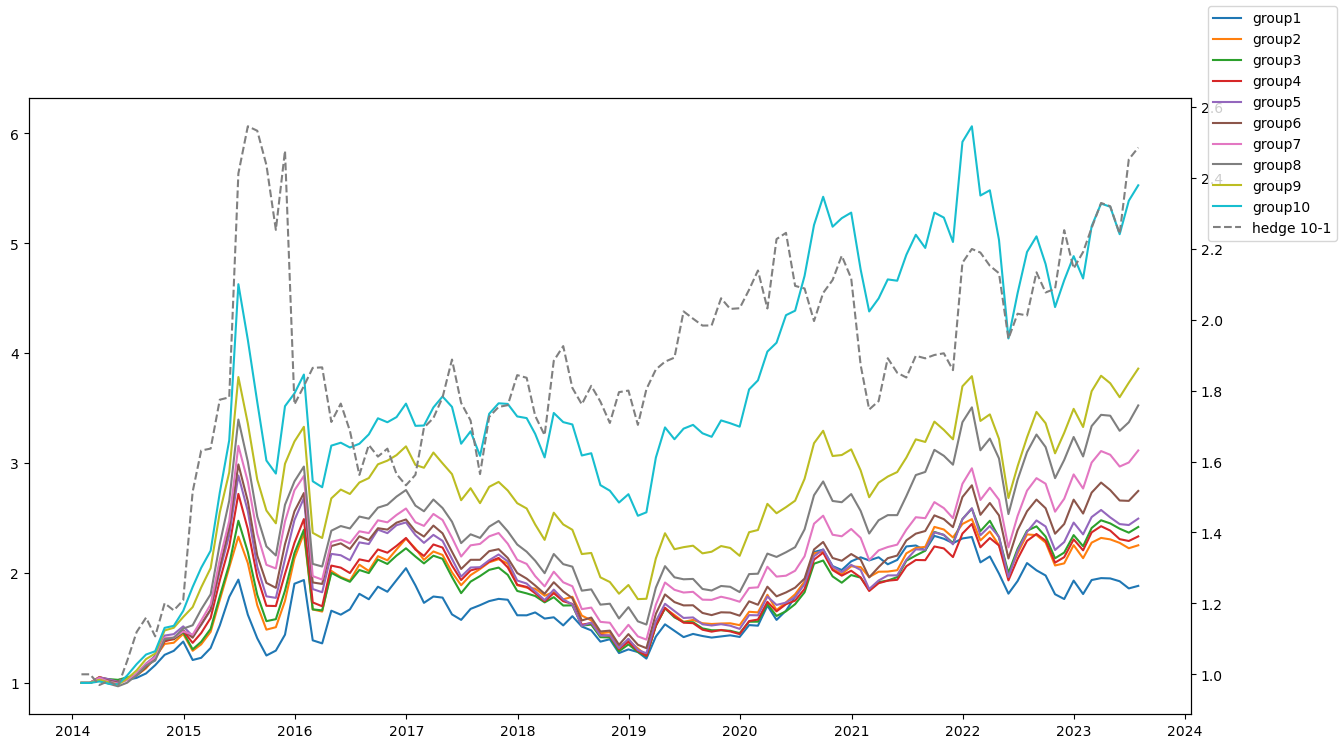

(            factor
 IC        0.015792
 ICIR      0.440898
 RankIC    0.015789
 RankICIR  0.361099,
           factor
 年化收益率:  0.101520
 波动率:    0.237050
 信息比率:   0.428264
 胜率:     0.582609
 最大回撤    0.397734)

### equal weighted

In [28]:
factor_ew = pd.DataFrame(np.nan, index= df_AMA_m.index, columns=df_AMA_m.columns)
n,d,t = features.shape
direction = np.array([1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, 1])
for i in range(t):
    #training set and features normalization
    feature = features[:,:,i]*direction
    valid_index = ~np.any(np.isnan(feature),axis = 1)
    X_train = feature[valid_index]
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    X_train = (X_train- mean) / std
    factor_ew.iloc[i, valid_index] = np.mean(X_train, axis=1).reshape((X_train.shape[0],))

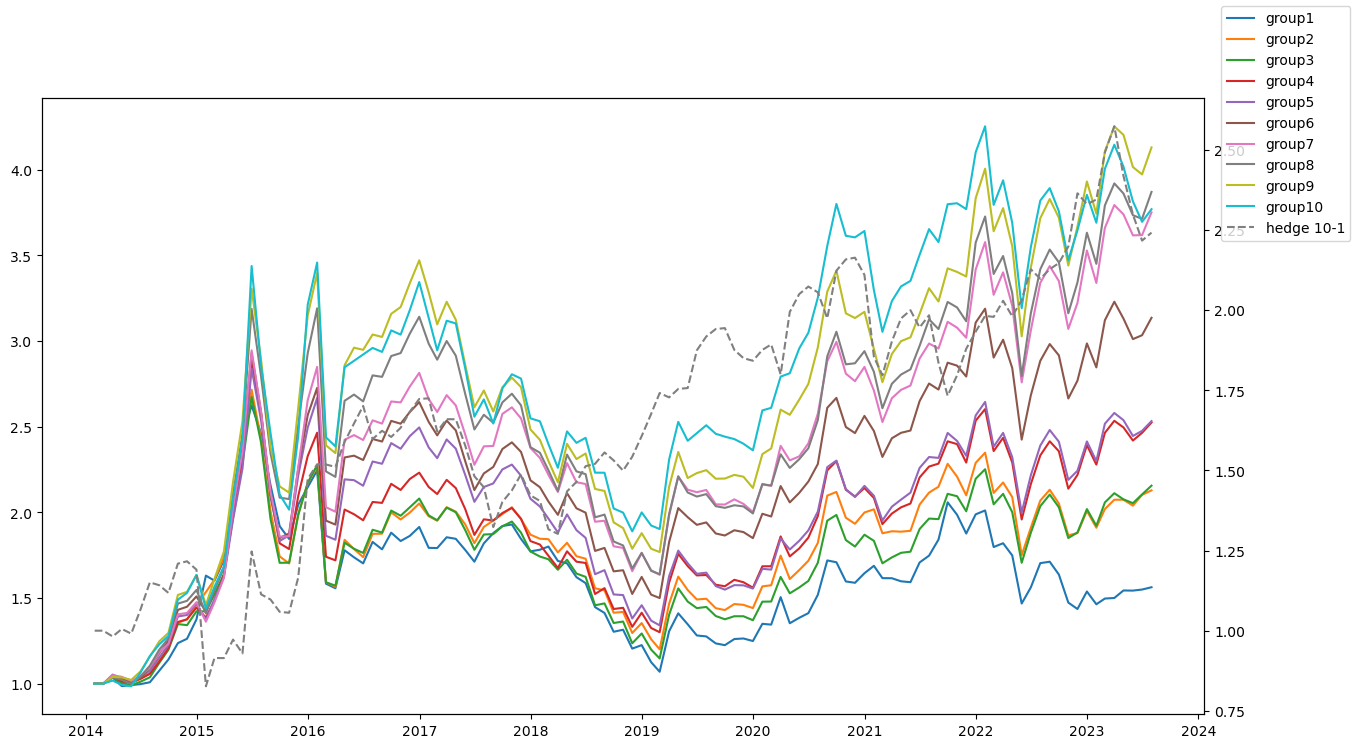

(            factor
 IC        0.024345
 ICIR      0.845882
 RankIC    0.031577
 RankICIR  0.817644,
           factor
 年化收益率:  0.094520
 波动率:    0.226000
 信息比率:   0.418228
 胜率:     0.582609
 最大回撤    0.320507)

In [29]:
test(factor_ew)

### linear regression

In [35]:
from sklearn import linear_model

factor_lr = pd.DataFrame(np.nan, index= df_AMA_m.index, columns=df_AMA_m.columns)
n,d,t = features.shape
for i in range(t):
    if i == 0:
        #training set and features normalization
        feature = features[:,:,i]
        valid_index = ~np.any(np.isnan(feature),axis = 1)
        X_train = feature[valid_index]
        mean = np.mean(X_train, axis=0)
        std = np.std(X_train, axis=0)
        X_train = (X_train- mean) / std
        factor_lr.iloc[i, valid_index] = np.mean(X_train, axis=1).reshape((X_train.shape[0],))
    else:
        #LR model training
        feature = features[:,:,:i].reshape((n*i, d))
        return_rate = rr[:,:,:i].reshape((n*i, 1))
        valid_index = ~((np.any(np.isnan(feature),axis = 1))|(np.any(np.isnan(return_rate),axis = 1))) #没有nan值的样本index
        X_train = feature[valid_index]
        mean = np.mean(X_train, axis=0)
        std = np.std(X_train, axis=0)
        X_train = (X_train- mean) / std
        y_train = return_rate[valid_index].reshape(-1)
        reg = linear_model.LinearRegression()
        reg.fit(X_train, y_train)
        # Normalization and Fit the current 
        X = features[:,:,i]
        valid_index = ~np.any(np.isnan(X),axis = 1)
        X_train = X[valid_index]
        mean = np.mean(X_train, axis=0)
        std = np.std(X_train, axis=0)
        X_train = (X_train- mean)/std
        factor_lr.iloc[i,valid_index] = reg.predict(X_train)  

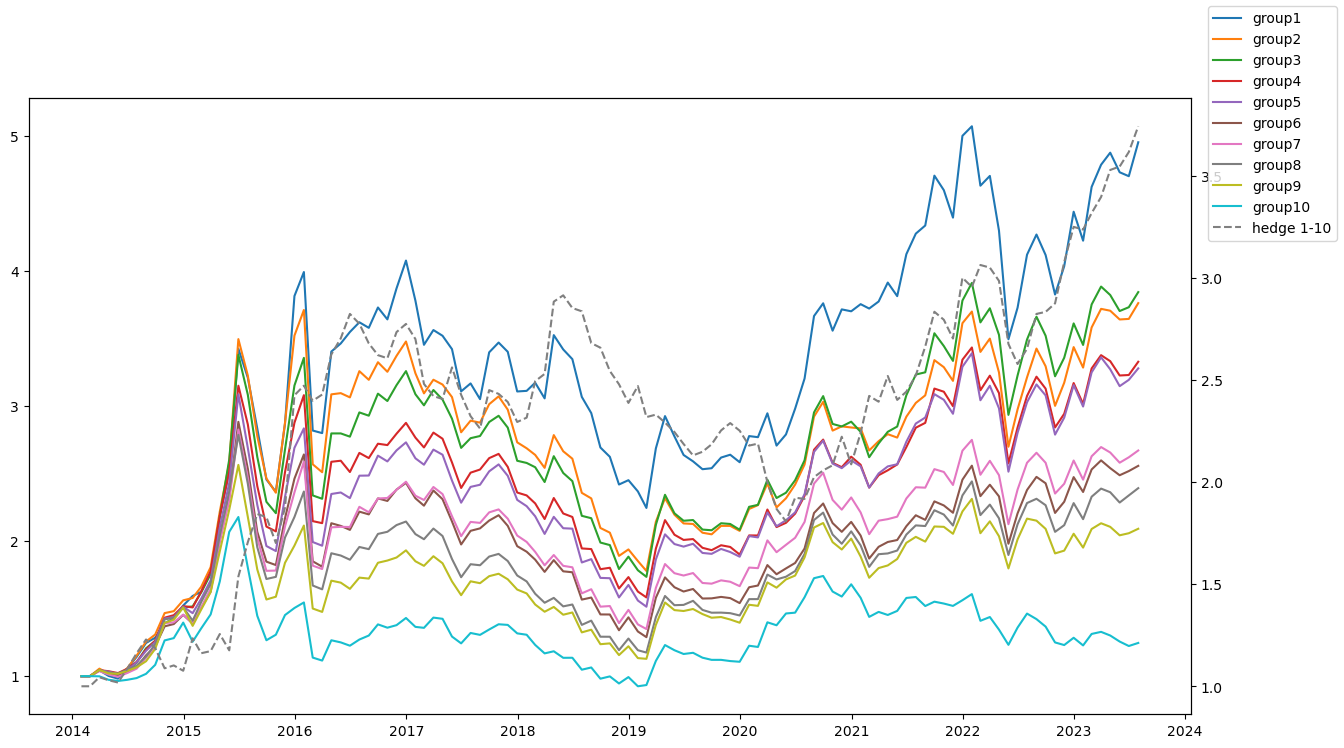

(            factor
 IC       -0.012914
 ICIR     -0.412281
 RankIC   -0.010679
 RankICIR -0.260268,
           factor
 年化收益率:  0.142045
 波动率:    0.215143
 信息比率:   0.660237
 胜率:     0.530435
 最大回撤    0.379885)

In [36]:
test(factor_lr)

### SVR

In [ ]:
from sklearn import svm

factor_svr = pd.DataFrame(np.nan, index= df_AMA_m.index, columns=df_AMA_m.columns)
n,d,t = features.shape
for i in range(t):
    if i == 0:
        #training set and features normalization
        feature = features[:,:,i]
        valid_index = ~np.any(np.isnan(feature),axis = 1)
        X_train = feature[valid_index]
        mean = np.mean(X_train, axis=0)
        std = np.std(X_train, axis=0)
        X_train = (X_train- mean) / std
        factor_svr.iloc[i, valid_index] = np.mean(X_train, axis=1).reshape((X_train.shape[0],))
        continue

    if i % 12 == 1:
        print(i)
        if i == 1:
            reg = svm.SVR()
            feature = features[:,:,:i].reshape((n*i, d))
            return_rate = rr[:,:,:i].reshape((n*i, 1))
            valid_index = ~((np.any(np.isnan(feature),axis = 1))|(np.any(np.isnan(return_rate),axis = 1))) #没有nan值的样本index
            X_train = feature[valid_index]
            mean = np.mean(X_train, axis=0)
            std = np.std(X_train, axis=0)
            X_train = (X_train- mean) / std
            y_train = return_rate[valid_index].reshape(-1)
            reg.fit(X_train, y_train)
        else:
            feature = features[:,:,(i - 12):i].reshape((n*12, d))
            return_rate = rr[:,:,(i-12):i].reshape((n*12, 1))
            valid_index = ~((np.any(np.isnan(feature),axis = 1))|(np.any(np.isnan(return_rate),axis = 1))) #没有nan值的样本index
            X_train = feature[valid_index]
            mean = np.mean(X_train, axis=0)
            std = np.std(X_train, axis=0)
            X_train = (X_train- mean) / std
            y_train = return_rate[valid_index].reshape(-1)
            reg.fit(X_train, y_train)
    # Normalization and Fit the current
    X = features[:,:,i]
    valid_index = ~np.any(np.isnan(X),axis = 1)
    X_train = X[valid_index]
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    X_train = (X_train- mean)/std
    factor_svr.iloc[i,valid_index] = reg.predict(X_train)

In [31]:
factor_svr = pd.read_csv('factor_svr.csv')
factor_svr['Date'] = pd.to_datetime(factor_svr['Date'])
factor_svr.set_index('Date', inplace=True)

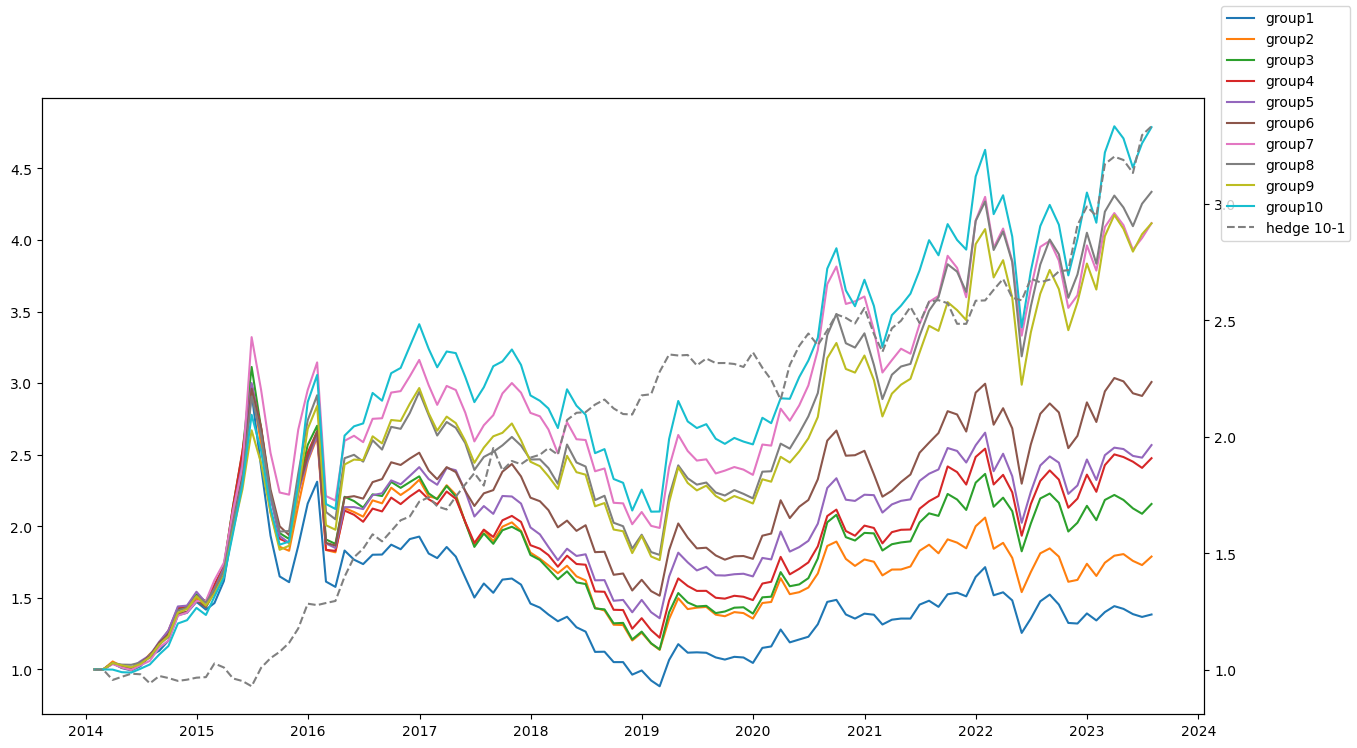

(            factor
 IC        0.030473
 ICIR      1.320353
 RankIC    0.035261
 RankICIR  1.218633,
           factor
 年化收益率:  0.134655
 波动率:    0.105528
 信息比率:   1.276015
 胜率:     0.626087
 最大回撤    0.095361)

In [35]:
test(factor_svr)

### Feature Selection
SVR + RFE

In [15]:
factor_svr_rfe = pd.read_csv('factor_svr_rfe.csv')
factor_svr_rfe['Date'] = pd.to_datetime(factor_svr_rfe['Date'])
factor_svr_rfe.set_index('Date', inplace=True)

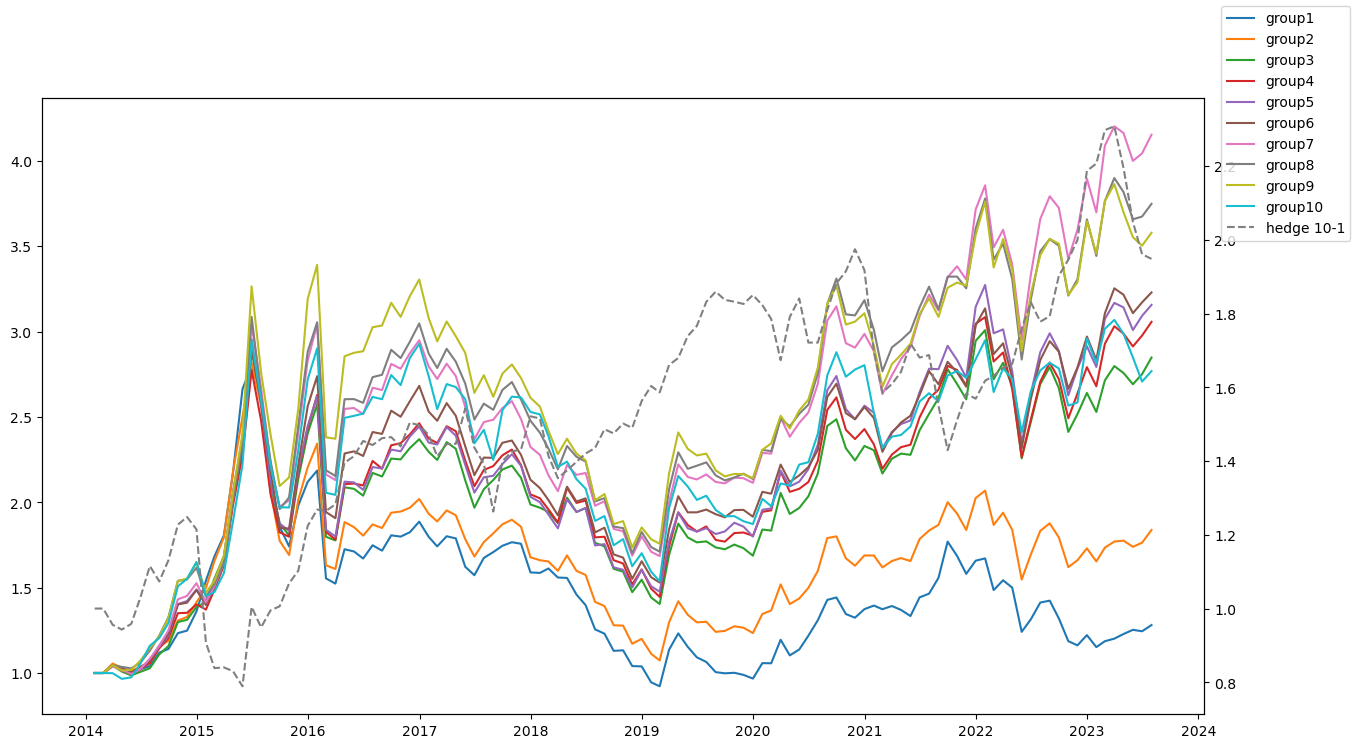

(            factor
 IC        0.011551
 ICIR      0.392501
 RankIC    0.033897
 RankICIR  0.847876,
           factor
 年化收益率:  0.084054
 波动率:    0.194909
 信息比率:   0.431246
 胜率:     0.626087
 最大回撤    0.367865)

In [16]:
test(factor_svr_rfe)